# Problem Statement

Five million Americans are currently living with heart diseases, and the numbers are expected to rise. It is very important to understand the factors which causes Heart-attacks so that certain precaution can be taken by individuals.
In-order to understand the reasons of the Heart-attack, a data was collected from various hospitals across US which is given in US_Heart_Patients.csv. In the data set there are Heart-Att indicates whether the person suffered from Heart attack or not.

Perform EDA on the data and build a model which will predict whether the person will suffer from Heart-attack or not.


## Importing required packages and dataset

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
from sklearn.ensemble import RandomForestClassifier

In [9]:
chd_df = pd.read_csv("azcabgptca.csv")

## Checking the data

In [10]:
chd_df.head(10) 

,Unnamed: 0,died,procedure,age,gender,los,type
0,1,0,1,73,0,51,0
1,2,0,0,67,0,30,1
2,3,0,1,69,0,43,0
3,4,0,1,65,0,32,0
4,5,0,1,79,0,42,1
5,6,0,1,68,0,33,1
6,7,0,0,74,0,22,1
7,8,0,1,66,0,30,1
8,9,0,1,66,0,30,0
9,10,0,0,65,1,9,1


In [11]:
chd_df.shape

(1959, 7)

In [12]:
chd_df.info()  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1959 entries, 0 to 1958
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   Unnamed: 0  1959 non-null   int64
 1   died        1959 non-null   int64
 2   procedure   1959 non-null   int64
 3   age         1959 non-null   int64
 4   gender      1959 non-null   int64
 5   los         1959 non-null   int64
 6   type        1959 non-null   int64
dtypes: int64(7)
memory usage: 107.3 KB


Gender column is of type object i.e. strings. This need to be converted to ordinal type for building RF model

# EDA

### Summary of the data

In [13]:
chd_df.describe(include="all")

,Unnamed: 0,died,procedure,age,gender,los,type
count,1959.000000,1959.000000,1959.000000,1959.000000,1959.000000,1959.000000,1959.000000
mean,980.000000,0.018377,0.474222,71.177642,0.692700,7.282797,0.456355
std,565.658908,0.134344,0.499463,4.024198,0.461492,5.601206,0.498219
min,1.000000,0.000000,0.000000,65.000000,0.000000,1.000000,0.000000
25%,490.500000,0.000000,0.000000,68.000000,0.000000,3.000000,0.000000
50%,980.000000,0.000000,0.000000,71.000000,1.000000,7.000000,0.000000
75%,1469.500000,0.000000,1.000000,74.000000,1.000000,10.000000,1.000000
max,1959.000000,1.000000,1.000000,79.000000,1.000000,51.000000,1.000000


### Frequency of the levels in the Gender column

In [14]:
# Get the count of Male and Female
chd_df.died.value_counts()

0    1923
1      36
Name: died, dtype: int64

### Proportion of observations in each of the target classes

In [17]:
chd_df['died'].value_counts()

0    1923
1      36
Name: died, dtype: int64

In [18]:
# Get the proportion in each class
chd_df['died'].value_counts(normalize=True)

0    0.981623
1    0.018377
Name: died, dtype: float64

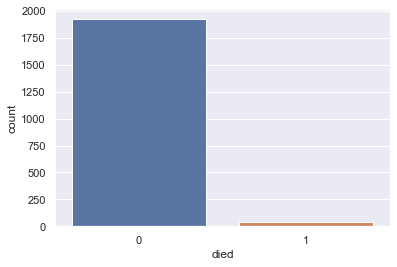

In [20]:
# countplot of target variables
import seaborn as sns
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="died", data=chd_df)

### Check for duplicate data

In [21]:
# Are there any duplicates ?
dups = chd_df.duplicated()
print('Number of duplicate rows = %d' % (dups.sum()))
chd_df[dups]

Number of duplicate rows = 0


,Unnamed: 0,died,procedure,age,gender,los,type


There are no duplicates in the data

### Check for missing value in any column

In [22]:
# Are there any missing values ?
chd_df.isnull().sum()

Unnamed: 0    0
died          0
procedure     0
age           0
gender        0
los           0
type          0
dtype: int64

Missing values exists for all the independent varibles with some variables having very high missing values

In [23]:
chd_df.dropna().shape

(1959, 7)

In [25]:
chd_df.columns

Index(['Unnamed: 0', 'died', 'procedure', 'age', 'gender', 'los', 'type'], dtype='object')

If we were to drop all the observations having missing values, then number of observations reduces from 4240 to 3616 rows for the same 16 columns.

As we see in the below boxplot continuous variables have outliers present.

So, we will impute the continuous variables with median value, and drop the missing values corresponding to categorical variables.

<AxesSubplot:>

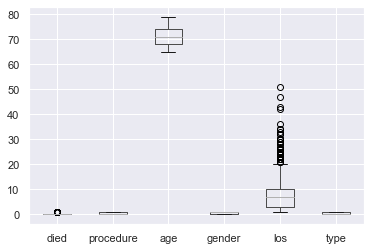

In [26]:
chd_df[['died', 'procedure', 'age', 'gender', 'los', 'type']].boxplot()

In [27]:
for column in chd_df[['died', 'procedure', 'age', 'gender', 'los', 'type']]:
    median = chd_df[column].median()
    chd_df[column] = chd_df[column].fillna(median)

In [28]:
chd_df.isnull().sum()

Unnamed: 0    0
died          0
procedure     0
age           0
gender        0
los           0
type          0
dtype: int64

Only categorical variables have misisng values now

In [29]:
chd_df.dropna(inplace=True)
chd_df.shape

(1959, 7)

After removing these missing values, the number of observations is now 4055

### Checking for Outliers

<AxesSubplot:>

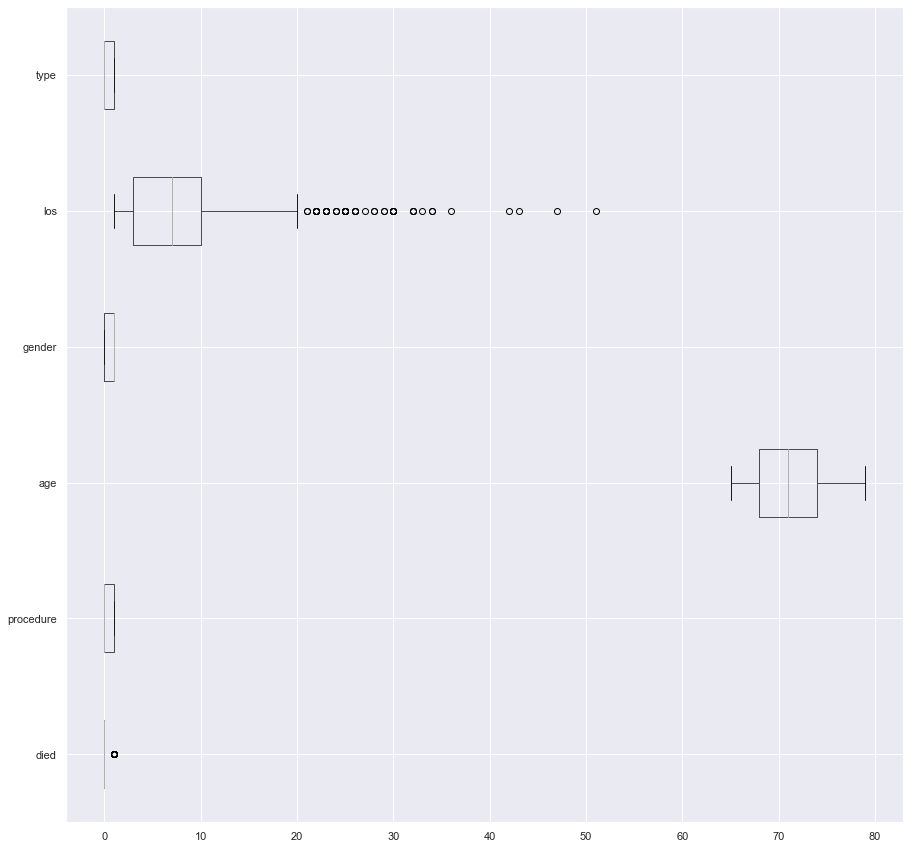

In [30]:
# construct box plot for continuous variables
plt.figure(figsize=(15,15))
chd_df[['died', 'procedure', 'age', 'gender', 'los', 'type']].boxplot(vert=0)

Outliers exists for most of the continuous variables, and also has many outliers

### Treating the Outliers

In [31]:
# Complete the function to calculate lower_range and upper_range
def treat_outlier(col):
    sorted(col)
    Q1,Q3=np.percentile(col,[25,75])
    IQR=Q3-Q1
    lower_range= Q1-(1.5 * IQR)
    upper_range= Q3+(1.5 * IQR)
    return lower_range, upper_range

In [32]:
for feature in chd_df[['died', 'procedure', 'age', 'gender', 'los', 'type']]: 
    lr,ur=treat_outlier(chd_df[feature])
    chd_df[feature]=np.where(chd_df[feature]>ur,ur,chd_df[feature])
    chd_df[feature]=np.where(chd_df[feature]<lr,lr,chd_df[feature])

<AxesSubplot:>

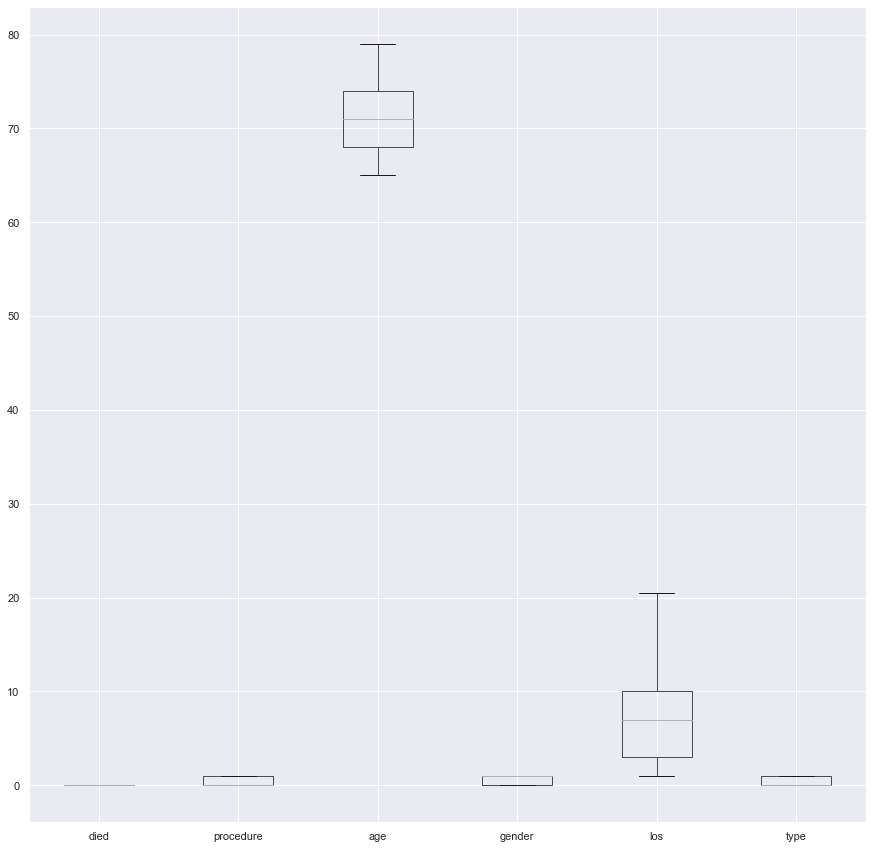

In [33]:
plt.figure(figsize=(15,15))
chd_df[['died', 'procedure', 'age', 'gender', 'los', 'type']].boxplot()

There are no outliers after treating them

### Checking pairwise distribution of the continuous variables

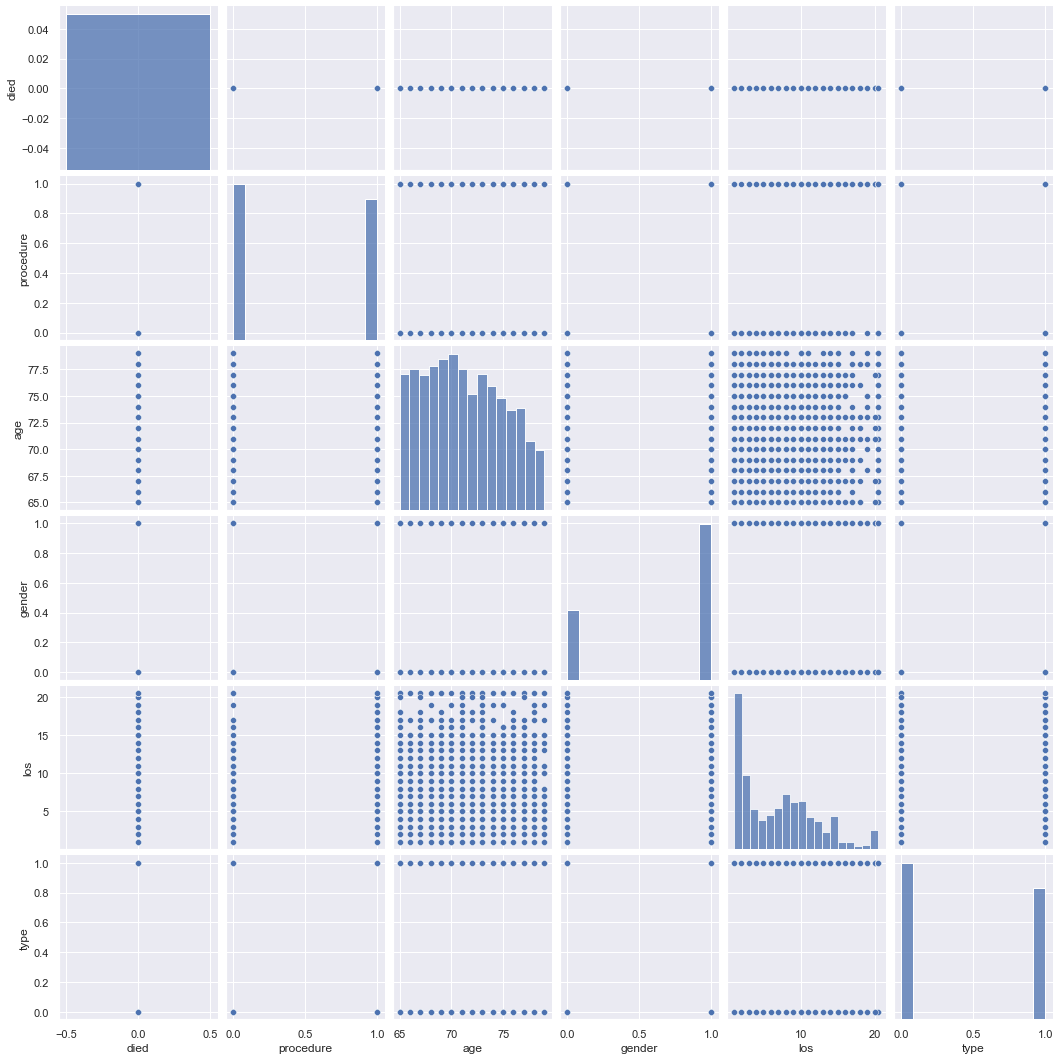

In [35]:
sns.pairplot(chd_df[[ 'died', 'procedure', 'age', 'gender', 'los', 'type']])

### Checking for Correlations

<AxesSubplot:>

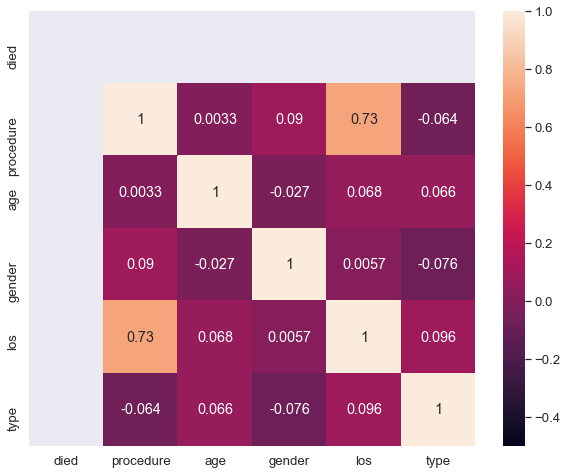

In [36]:
# construct heatmap with only continuous variables
plt.figure(figsize=(10,8))
sns.set(font_scale=1.2)
sns.heatmap(chd_df[['died', 'procedure', 'age', 'gender', 'los', 'type']].corr(), annot=True,vmin=-0.5,vmax=1)

In [37]:
chd_df.head(10)

,Unnamed: 0,died,procedure,age,gender,los,type
0,1,0.0,1.0,73.0,0.0,20.5,0.0
1,2,0.0,0.0,67.0,0.0,20.5,1.0
2,3,0.0,1.0,69.0,0.0,20.5,0.0
3,4,0.0,1.0,65.0,0.0,20.5,0.0
4,5,0.0,1.0,79.0,0.0,20.5,1.0
5,6,0.0,1.0,68.0,0.0,20.5,1.0
6,7,0.0,0.0,74.0,0.0,20.5,1.0
7,8,0.0,1.0,66.0,0.0,20.5,1.0
8,9,0.0,1.0,66.0,0.0,20.5,0.0
9,10,0.0,0.0,65.0,1.0,9.0,1.0


   
      
Decision tree in Python can take only numerical / categorical colums. It cannot take string / obeject types. 
The following code loops through each column and checks if the column type is object then converts those columns into  categorical with each distinct value becoming a category or code.

In [38]:
for feature in chd_df.columns: 
    if chd_df[feature].dtype == 'object':
        chd_df[feature] = pd.Categorical(chd_df[feature]).codes 

In [39]:
chd_df.head(10)

,Unnamed: 0,died,procedure,age,gender,los,type
0,1,0.0,1.0,73.0,0.0,20.5,0.0
1,2,0.0,0.0,67.0,0.0,20.5,1.0
2,3,0.0,1.0,69.0,0.0,20.5,0.0
3,4,0.0,1.0,65.0,0.0,20.5,0.0
4,5,0.0,1.0,79.0,0.0,20.5,1.0
5,6,0.0,1.0,68.0,0.0,20.5,1.0
6,7,0.0,0.0,74.0,0.0,20.5,1.0
7,8,0.0,1.0,66.0,0.0,20.5,1.0
8,9,0.0,1.0,66.0,0.0,20.5,0.0
9,10,0.0,0.0,65.0,1.0,9.0,1.0


Female converted to 0, and Male to 1

In [40]:
chd_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1959 entries, 0 to 1958
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  1959 non-null   int64  
 1   died        1959 non-null   float64
 2   procedure   1959 non-null   float64
 3   age         1959 non-null   float64
 4   gender      1959 non-null   float64
 5   los         1959 non-null   float64
 6   type        1959 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 122.4 KB


### Capture the target column into separate vectors for training set and test set

In [41]:
X = chd_df.drop(["died"], axis=1)

y = chd_df.pop("died")

### Splitting data into training and test set

In [42]:
from sklearn.model_selection import train_test_split

X_train, X_test, train_labels, test_labels = train_test_split(X, y, test_size=.30, random_state=1)


In [43]:
train_labels.value_counts()

0.0    1371
Name: died, dtype: int64

In [44]:
train_labels.value_counts(normalize=True)

0.0    1.0
Name: died, dtype: float64

In [45]:
test_labels.value_counts()

0.0    588
Name: died, dtype: int64

In [46]:
test_labels.value_counts(normalize=True)

0.0    1.0
Name: died, dtype: float64

Observations are almost equally distributed between the train and test sets w.r.t target classes

# Ensemble RandomForest Classifier

#### Building the Random Forest model

**Importance of Random State**

**The important thing is that everytime you use any natural number, you will always get the same output the first time you make the model which is similar to random state while train test split**

In [47]:
# To understand the differences of different random states affecting Out-of-Bag score
random_state=[0,23,42]
for i in random_state:
    rf=RandomForestClassifier(random_state=i,oob_score=True)
    rf.fit(X_train,train_labels)
    print(rf.oob_score_)

1.0
1.0
1.0


In [49]:
#Build a RandomForestCassifier wit n_estimators 100, max_features 6, andfit it on the training data
rfcl = RandomForestClassifier(n_estimators = 500,random_state=0)
rfcl = rfcl.fit(X_train, train_labels)

In [50]:
rfcl

RandomForestClassifier(n_estimators=500, random_state=0)

##### Predicting Train and Test data with the RF Model

In [51]:
ytrain_predict = rfcl.predict(X_train)
ytest_predict = rfcl.predict(X_test)

**Train Accuracy**


In [52]:
rfcl.score(X_train,train_labels)

1.0

#### Evaluating model performance with confusion matrix

In [53]:
from sklearn.metrics import confusion_matrix,classification_report

#### Evaluating model performance on the training data

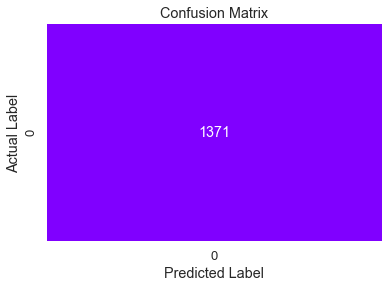

In [54]:
# Get the confusion matrix on the train data
confusion_matrix(train_labels,ytrain_predict)
sns.heatmap(confusion_matrix(train_labels,ytrain_predict),annot=True, fmt='d',cbar=False, cmap='rainbow')
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.title('Confusion Matrix')
plt.show()

In [55]:
print(classification_report(train_labels,ytrain_predict))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      1371

    accuracy                           1.00      1371
   macro avg       1.00      1.00      1.00      1371
weighted avg       1.00      1.00      1.00      1371



In [56]:
print('Accuracy', ((2424+414)/(2424+414)))
print('Sensitivity',((414/414))) #TP/Actual yes
print('Specificity',(2424/2424)) #TN/Actual no
print('Precision',(414/414)) #TP/Predicted yes

Accuracy 1.0
Sensitivity 1.0
Specificity 1.0
Precision 1.0


In [57]:
from sklearn.metrics import roc_curve,roc_auc_score
rf_fpr, rf_tpr,_=roc_curve(train_labels,rfcl.predict_proba(X_train)[:,1])
plt.figure(figsize=(12,7))
plt.plot(rf_fpr,rf_tpr, marker='x', label='Random Forest')
plt.plot(np.arange(0,1.1,0.1),np.arange(0,1.1,0.1))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.show()
print('Area under Curve is', roc_auc_score(train_labels,rfcl.predict_proba(X_train)[:,1]))

IndexError: index 1 is out of bounds for axis 1 with size 1

#### Evaluating model performance on the test data

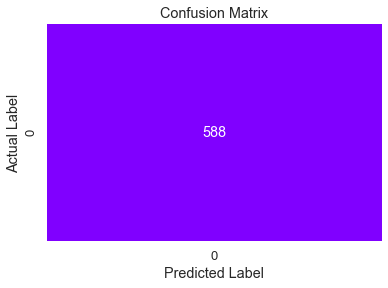

In [58]:
confusion_matrix(test_labels,ytest_predict)
sns.heatmap(confusion_matrix(test_labels,ytest_predict),annot=True, fmt='d',cbar=False, cmap='rainbow')
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.title('Confusion Matrix')
plt.show()

In [59]:
print(classification_report(test_labels,ytest_predict))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       588

    accuracy                           1.00       588
   macro avg       1.00      1.00      1.00       588
weighted avg       1.00      1.00      1.00       588



In [60]:
print('Accuracy', ((1019+13)/(1019+3+182+13)))
print('Sensitivity',((13/(13+182)))) 
print('Specificity',(1019/(1019+3)))
print('Precision',(13/(13+3)))

Accuracy 0.847986852917009
Sensitivity 0.06666666666666667
Specificity 0.99706457925636
Precision 0.8125


**Test Accuracy**

In [61]:
rfcl.score(X_test,test_labels)

1.0

In [62]:
#from sklearn.metrics import roc_curve,roc_auc_score
rf_fpr, rf_tpr,_=roc_curve(test_labels,rfcl.predict_proba(X_test)[:,1])
plt.figure(figsize=(12,7))
plt.plot(rf_fpr,rf_tpr, marker='x', label='Random Forest')
plt.plot(np.arange(0,1.1,0.1),np.arange(0,1.1,0.1))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.show()
print('Area under Curve is', roc_auc_score(test_labels,rfcl.predict_proba(X_test)[:,1]))

IndexError: index 1 is out of bounds for axis 1 with size 1

# Result:

Area under the curve on the training data is 100%, which indicates very high performance that all classes have been correctly classified. Whereas on the test data model performance is average with AUC 69%, which is very less compare to the performance of the training data.  
  

Since we are building a model to predict if a person will have a heart disease or not, for practical purposes, we will be more interested in correctly classifying 1 (having heart disease) than 0(not having heart disease). 

If a person not having a heart disease, is incorrectly predicted to have a heart disease, in this situation, the cost and other impact to life is less severe, than when we incorrectly predict a person, who actually have a heart disease, as not having a heart disease.

From the Random Forest model,looking at the Accuracy,Sensitivity,Speficity,Recall and AUC, we have 100% results on the training data, whereas on the Test data, performance is lesser,especially in predicting Class 1.  
 
This is because overfitting has happened on the training data, and therefore the model is weak in generalizing and predicting any new data.

In this model, we have hard-coded the hyper parameter values. We can optimize/fine-tune the random forest model, by trying different values for the hyper parameters to see if the model performance is improving.

### Grid Search for finding out the optimal values for the hyper parameters

Note: runs for longer time on more data with more params

In [63]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'max_depth': [5,7,10],
    'max_features': [4,6],
    'min_samples_leaf': [5,10],
    'min_samples_split': [50,100],
    'n_estimators': [100,200,300]
}

rfcl = RandomForestClassifier(random_state=0)

grid_search = GridSearchCV(estimator = rfcl, param_grid = param_grid, cv = 10)

In [64]:
grid_search.fit(X_train, train_labels)

GridSearchCV(cv=10, estimator=RandomForestClassifier(random_state=0),
             param_grid={'max_depth': [5, 7, 10], 'max_features': [4, 6],
                         'min_samples_leaf': [5, 10],
                         'min_samples_split': [50, 100],
                         'n_estimators': [100, 200, 300]})

In [65]:
grid_search.best_params_

{'max_depth': 5,
 'max_features': 4,
 'min_samples_leaf': 5,
 'min_samples_split': 50,
 'n_estimators': 100}

In [66]:
best_grid = grid_search.best_estimator_

In [67]:
best_grid

RandomForestClassifier(max_depth=5, max_features=4, min_samples_leaf=5,
                       min_samples_split=50, random_state=0)

In [68]:
ytrain_predict = best_grid.predict(X_train)
ytest_predict = best_grid.predict(X_test)

In [69]:
confusion_matrix(train_labels,ytrain_predict)


array([[1371]], dtype=int64)

In [70]:
print(classification_report(train_labels,ytrain_predict))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      1371

    accuracy                           1.00      1371
   macro avg       1.00      1.00      1.00      1371
weighted avg       1.00      1.00      1.00      1371



In [71]:
#from sklearn.metrics import roc_curve,roc_auc_score
rf_fpr, rf_tpr,_=roc_curve(train_labels,best_grid.predict_proba(X_train)[:,1])
plt.figure(figsize=(12,7))
plt.plot(rf_fpr,rf_tpr, marker='x', label='Random Forest')
plt.plot(np.arange(0,1.1,0.1),np.arange(0,1.1,0.1))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.show()
print('Area under Curve is', roc_auc_score(train_labels,best_grid.predict_proba(X_train)[:,1]))

IndexError: index 1 is out of bounds for axis 1 with size 1

In [ ]:
confusion_matrix(test_labels,ytest_predict)


In [ ]:
print(classification_report(test_labels,ytest_predict))

In [ ]:
#from sklearn.metrics import roc_curve,roc_auc_score
rf_fpr, rf_tpr,_=roc_curve(test_labels,best_grid.predict_proba(X_test)[:,1])
plt.figure(figsize=(12,7))
plt.plot(rf_fpr,rf_tpr, marker='x', label='Random Forest')
plt.plot(np.arange(0,1.1,0.1),np.arange(0,1.1,0.1))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.show()
print('Area under Curve is', roc_auc_score(test_labels,best_grid.predict_proba(X_test)[:,1]))

# Final Conclusion:

Here, we can see that even when we try other values for the hyper parameters, the model performance is not improving much. 

AUC is for train is 87 % and for test it is 70%. The problem of over fitting still exist, as there is a 17% gap between the train and test set. But still, the model is useful only in predicting class 0, and not class 1.

This is because, the dataset i`ms unbalanced, and so we have a class imbalance problem.

In the real world datasets, most of the time you will come across unbalanced datasets. To build a more robust classification model, this class imbalance needs to be addressed before building the model. This will be applicable to any kind of classification model. Once this issue is addressed and the model is built, further model tuning/optimization using grid search will result in improved performance. 
 
You will learn to deal with such imbalance in data using different performance improvement methods in the Machine Learning Course.
